# Model Validation

- model evaluation/comparison
- the tuning of hyperparameters

https://blog.cambridgecoding.com/2016/03/24/misleading-modelling-overfitting-cross-validation-and-the-bias-variance-trade-off/

In [33]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Use seaborn for plotting defaults
import seaborn as sns; sns.set()

In [34]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

In [35]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [36]:
y_pred = clf.predict(X)

print("{0} / {1} correct".format(np.sum(y == y_pred), len(y)))

1797 / 1797 correct


In [8]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [9]:
y_pred = clf.predict(X)
print("{0} / {1} correct".format(np.sum(y == y_pred), len(y)))

1797 / 1797 correct


It seems we have a perfect classifier!

**Question: what's wrong with this?**

We made the mistake of testing our data on the same set of data that was used for training. This is not generally a good idea. If we optimize our estimator this way, we will tend to over-fit the data: that is, we learn the noise.
A better way to test a model is to use a hold-out set which doesn't enter the training. We've seen this before using scikit-learn's train/test split utility:

In [37]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66)
X_train.shape, X_test.shape

((1186, 64), (611, 64))

In [47]:
# clf = DecisionTreeClassifier()
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

602 / 611 correct


The metric we're using here, comparing the number of matches to the total number of samples, is known as the accuracy score

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.98527004909983629

In [49]:
# alternatively directly within the model
clf.score(X_test, y_test)

0.98527004909983629

In [50]:
for n_neighbors in [1, 5, 10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(n_neighbors, knn.score(X_test, y_test))

1 0.9852700491
5 0.981996726678
10 0.975450081833
20 0.959083469722
30 0.952536824877


In [32]:
for depth in [None, 2, 3, 5, 8, 10, 20]:
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    print(depth, tree.score(X_test, y_test))

None 0.846153846154
2 0.281505728314
3 0.427168576105
5 0.73977086743
8 0.847790507365
10 0.834697217676
20 0.849427168576


### Cross-Validation

One problem with validation sets is that you "lose" some of the data. Above, we've only used 3/4 of the data for the training, and used 1/4 for the validation. Another option is to use 2-fold cross-validation, where we split the sample in half and perform the validation twice:

In [51]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=0)
X1.shape, X2.shape

((898, 64), (899, 64))

In [57]:
score1 = KNeighborsClassifier(1).fit(X2, y2).score(X1, y1)
score2 = KNeighborsClassifier(1).fit(X1, y1).score(X2, y2)
print(score1)
print(score2)
print((score1+score2)/2)

0.983296213808
0.982202447164
0.982749330486


In [60]:
from sklearn.cross_validation import cross_val_score
cv = cross_val_score(clf, X, y, cv=2)
cv.mean()

0.96048785080069765

#### K-fold Cross-Validation

In [61]:
cross_val_score(KNeighborsClassifier(1), X, y, cv=5)

array([ 0.96153846,  0.95303867,  0.96657382,  0.98879552,  0.95492958])

## Bias-Variance Trade-off, Overfitting, Underfitting and Model Selection

Selecting the optimal model for your data is what makes the difference between a good and a bad data scientist.

If our estimator is underperforming, how should we move forward?

- Use simpler or more complicated model?
- Add more features to each observed data point?
- Add more training samples?

Sometimes using a more complicated model will give worse results because we fit the noise.

In [62]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

In [63]:
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

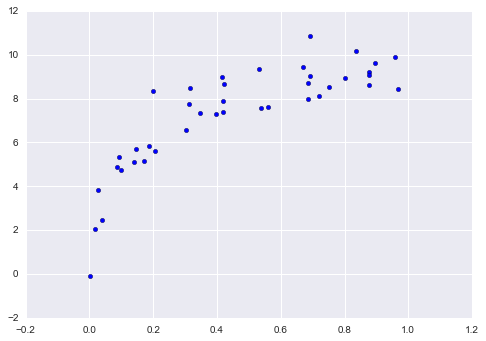

In [64]:
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

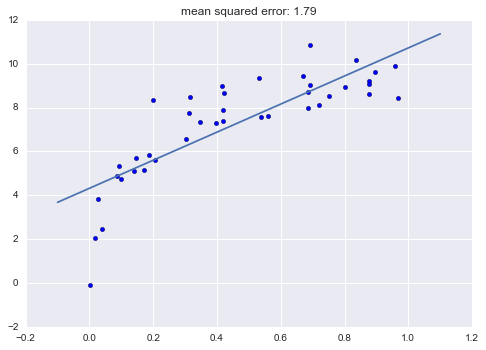

In [65]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

Clearly this model is not a good choice. We say that this model is biased, or that it under-fits the data.

In [81]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=1, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

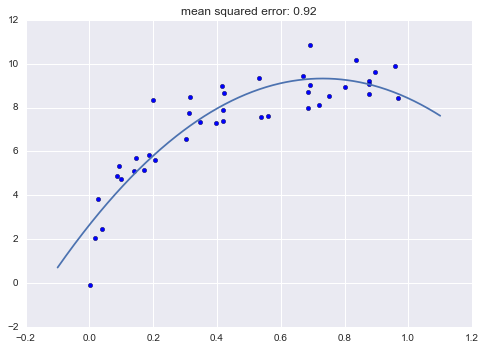

In [68]:
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

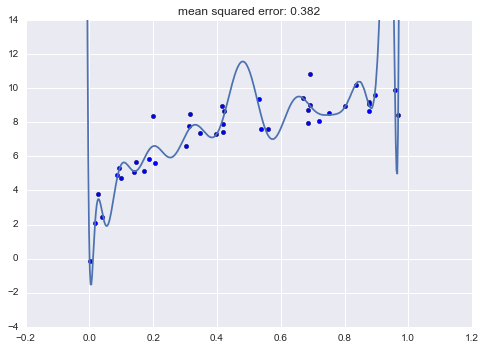

In [78]:
model = PolynomialRegression(20)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.ylim(-4, 14);

The resulting fit is no longer reflecting the true underlying distribution, but is more sensitive to the noise in the training data. For this reason, we call it a high-variance model, and we say that it over-fits the data.

### Detecting over-fitting with Cross-Validation

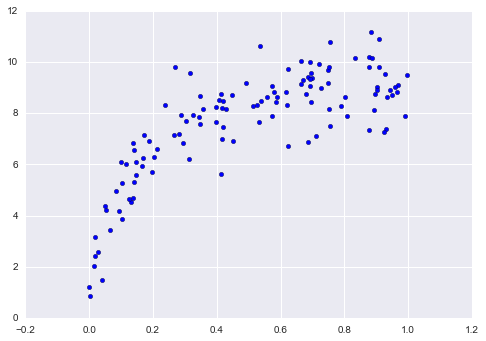

In [79]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [82]:
from sklearn.learning_curve import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(0, 18)
val_train, val_test = validation_curve(PolynomialRegression(), X, y,
                                       'polynomialfeatures__degree', degree, cv=7,
                                       scoring=rms_error)

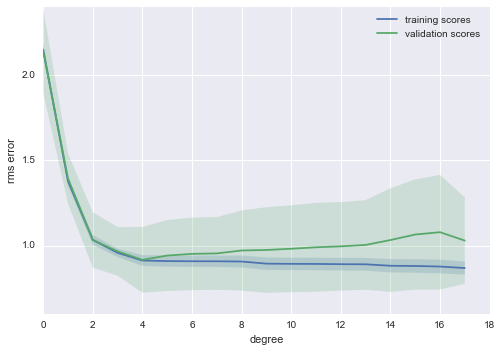

In [83]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend();

1. For a small model complexity, the training error and validation error are **high** and **very similar**. This indicates that the model is **under-fitting** the data: it doesn't have enough complexity to represent the data. Another way of putting it is that this is a **high-bias** model.

2. As the model complexity grows, the **training and validation scores diverge**. The training error decreases, however the validation error gets higher. This indicates that the model is **over-fitting** the data: it has so much flexibility, that it fits the noise rather than the underlying trend. Another way of putting it is that this is a **high-variance** model.

3. Note that the training score (nearly) always improves with model complexity. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is around 5 terms.

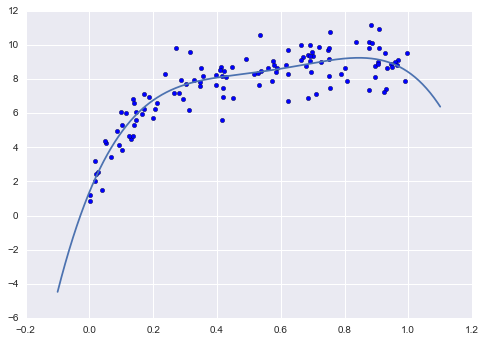

In [84]:
# best fit is the sweet spot
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test));

<img src="figures/underfitting.png">

### Detecting Data Sufficiency with Learning Curves

The exact turning-point of the tradeoff between bias and variance is highly dependent on the number of training points used.

Here we'll illustrate the use of *learning curves*.
The idea is to plot the mean-squared-error for the training and test set as a function of Number of Training Points

In [85]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(degree=3):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(PolynomialRegression(degree),
                                                  X, y, train_sizes, cv=5,
                                                  scoring=rms_error)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()

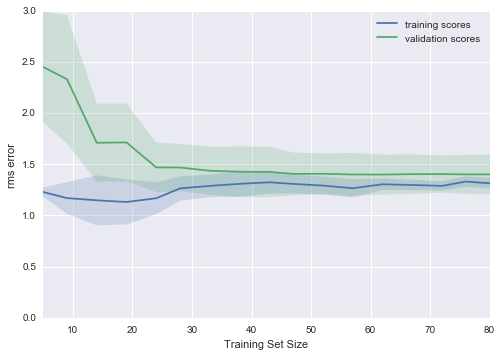

In [86]:
plot_learning_curve(1)

This shows a typical learning curve: for very few training points, there is a large separation between the training and test error, which indicates **over-fitting**. Given the same model, for a large number of training points, the training and testing errors converge, which indicates potential **under-fitting**.

As you add more data points, the training error will never increase, and the testing error will never decrease (why do you think this is?)

It is easy to see that, in this plot, if you'd like to reduce the MSE down to the nominal value of 1.0 (which is the magnitude of the scatter we put in when constructing the data), then adding more samples will never get you there. For $d=1$, the two curves have converged and cannot move lower. What about for a larger value of $d$?

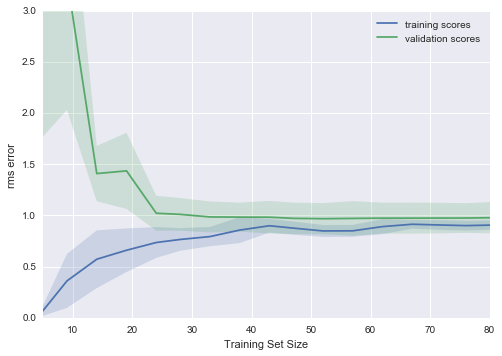

In [87]:
plot_learning_curve(3)

Here we see that by adding more model complexity, we've managed to lower the level of convergence to an rms error of 1.0!

What if we get even more complex?

For an even more complex model, we still converge, but the convergence only happens for large amounts of training data.

So we see the following:

- you can cause the lines to converge by adding more points or by simplifying the model.
- you can bring the convergence error down only by increasing the complexity of the model.

Thus these curves can give you hints about how you might improve a sub-optimal model.

- If the curves are already close together, you need more model complexity.
- If the curves are far apart, you might also improve the model by adding more data.

## Summary

We've gone over several useful tools for model validation

- The **Training Score** shows how well a model fits the data it was trained on. This is not a good indication of model effectiveness
- The **Validation Score** shows how well a model fits hold-out data. The most effective method is some form of cross-validation, where multiple hold-out sets are used.
- **Validation Curves** are a plot of validation score and training score as a function of **model complexity**:
  + when the two curves are close, it indicates *underfitting*
  + when the two curves are separated, it indicates *overfitting*
  + the "sweet spot" is in the middle
- **Learning Curves** are a plot of the validation score and training score as a function of **Number of training samples**
  + when the curves are close, it indicates *underfitting*, and adding more data will not generally improve the estimator.
  + when the curves are far apart, it indicates *overfitting*, and adding more data may increase the effectiveness of the model.
  
These tools are powerful means of evaluating your model on your data.

### Find a Bigger Hammer = Grid Search

In [211]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

In [165]:
datafile ='data/1_4_17_11_2013.csv'
data = np.genfromtxt(datafile , delimiter=',')
X, y = data[:,1:], data[:,0]

In [166]:
pca = PCA(2)
X_2d = pca.fit_transform(X)

In [167]:
X_2d.shape

(1805, 2)

In [178]:
clf = SVC(kernel='rbf', class_weight='balanced')

In [198]:
X_train, X_test, y_train, y_test = train_test_split(
X_2d, y, test_size=0.25, random_state=0)

In [199]:
clf.fit(X_train, y_train)

SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.10000000000000001,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [200]:
clf.score(X_test, y_test)

0.97787610619469023

In [201]:
svc_params = {
    'C': np.logspace(-2, 2, 5),
    'gamma': np.logspace(-4, 0, 5),
}

In [203]:
grid = GridSearchCV(clf, svc_params, cv=5, n_jobs=-1)
grid.fit(X_2d, y)
print(grid.best_params_, grid.best_score_)

{'C': 10.0, 'gamma': 0.10000000000000001} 0.935180055402


In [204]:
def plot_parameters(grid):
    score_dict = grid.grid_scores_

    # We extract just the scores
    scores = [x[1] for x in score_dict]
    scores = np.array(scores).reshape(len(svc_params['C']), len(svc_params['gamma']))

    # draw heatmap of accuracy as a function of gamma and C
    plt.figure(figsize=(5, 5))
    #plt.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.7)
    plt.imshow(scores, interpolation='nearest',  cmap=plt.cm.Blues) # binary
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(svc_params['gamma'])), svc_params['gamma'], rotation=45)
    plt.yticks(np.arange(len(svc_params['C'])), svc_params['C'])

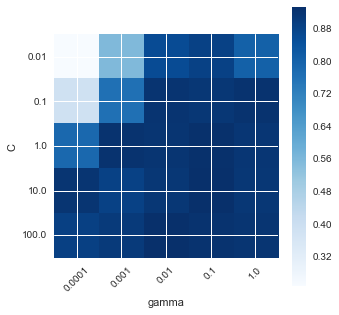

In [205]:
plot_parameters(grid)

In [208]:
#clf = SVC(kernel='rbf', class_weight='balanced', 
#          C=grid.best_params_['C'],
#          gamma=grid.best_params_['gamma'])
#clf.fit(X_train, y_tra)
#clf.score(X_2d, y)

y_pred = grid.predict(X_test)
grid.score(X_test, y_test)

0.98893805309734517

In [212]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        1.0       0.98      1.00      0.99        61
        2.0       1.00      0.99      0.99        74
        3.0       0.99      0.99      0.99       303
        4.0       0.86      0.86      0.86        14

avg / total       0.99      0.99      0.99       452

